In [90]:
import pandas as pd
from scipy import differentiate
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import requests


# Data Preprocessing

In [91]:
#Get aiirfare and demand dataset
url = "https://users.stat.ufl.edu/~winner/data/airq402.dat"
r = requests.get(url)

#load into pandas dataframe
df_airfare = pd.read_csv(StringIO(r.text), sep=r'\s+', header=None)
#Define column header
df_airfare.columns = ['1','2','3','4','5','6','7','8','9','10','11']

#Do one-hot encoding to replace categorical variables with numerical values
df_airfare = pd.get_dummies(df_airfare).replace({False: 0, True: 1})

#Fill missing values (if any) with the mean of the corresponding column
df_airfare = df_airfare.fillna(df_airfare.mean())

#Split into training and test data
df_airfare_train = df_airfare.sample(frac=0.8, axis=0)
df_airfare_test = df_airfare.drop(df_airfare_train.index)

#Choosing feature '11' as target feature for both training and test data
ytrain_airfare = df_airfare_train['11'].to_numpy()
Xtrain_airfare = df_airfare_train.drop('11', axis=1).to_numpy()

ytest_airfare = df_airfare_test['11'].to_numpy()
Xtest_airfare = df_airfare_test.drop('11', axis=1).to_numpy()


/tmp/ipykernel_14105/2229483762.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_airfare = pd.get_dummies(df_airfare).replace({False: 0, True: 1})


In [92]:
#Similarly do the same for the red and white wine datasets, where the feature 'quality' is chosen as target feature
df_wine_red = pd.read_csv('winequality-red.csv', sep=';')
df_wine_red = pd.get_dummies(df_wine_red)
df_wine_red = df_wine_red.fillna(df_wine_red.mean())
df_wine_red_train = df_wine_red.sample(frac=0.8, axis=0)
df_wine_red_test = df_wine_red.drop(df_wine_red_train.index)

ytrain_wine_red = df_wine_red_train['quality'].to_numpy()
Xtrain_wine_red = df_wine_red_train.drop('quality', axis=1).to_numpy()

ytest_wine_red = df_wine_red_test['quality'].to_numpy()
Xtest_wine_red = df_wine_red_test.drop('quality', axis=1).to_numpy()



df_wine_white = pd.read_csv('winequality-white.csv', sep=';')
df_wine_white = pd.get_dummies(df_wine_white)
df_wine_white = df_wine_white.fillna(df_wine_white.mean())
df_wine_white_train = df_wine_white.sample(frac=0.8, axis=0)
df_wine_white_test = df_wine_white.drop(df_wine_white_train.index)

ytrain_wine_white = df_wine_white_train['quality'].to_numpy()
Xtrain_wine_white = df_wine_white_train.drop('quality', axis=1).to_numpy()

ytest_wine_white = df_wine_white_test['quality'].to_numpy()
Xtest_wine_white = df_wine_white_test.drop('quality', axis=1).to_numpy()

# Linear regression with Gradient descent

In [93]:
def steplength_armijo(f, x, d, delta):

    """
    Computes the step length using armijo function

    Parameters:
        f (callable): Function to minimize.
        x (np.ndarray): Current position (point in parameter space).
        d (np.ndarray): Gradient (descent direction).
        delta (float): Minimum steepness.
    Returns:
        float: Step length.

    """

    alpha = 1
    while f(x) - f(x - alpha * d) < alpha*delta*(d.T @ d):
        alpha /= 2

    return alpha


def steplength_bolddriver(f, x, d, alpha_old, alpha_plus, alpha_minus):

    """
    Computes the step length using the Bold Driver heuristic.

    Parameters:
        f (callable): Function to minimize.
        x (np.ndarray): Current position (point in parameter space).
        d (np.ndarray): Gradient (descent direction).
        alpha_old (float): Step length from the previous iteration.
        alpha_plus (float): Factor to increase the step length (e.g., 1.1).
        alpha_minus (float): Factor to decrease the step length (e.g., 0.5).

    Returns:
        float: Computed step length alpha.
    """

    alpha = alpha_old*alpha_plus
    while f(x) - f(x - alpha * d) <= 0:
        alpha *= alpha_minus

    return alpha

def minimize_gradient_descent(f, df, beta_0, alpha, step_function, i_max, eps):

    """
    Parameters:
        f (callable): Function to minimize.
        df (callable): Gradient (descent direction).
        beta_0 (np.ndarray): Initial value for descent.
        alpha (float): Constant/Initial step length.
        step_function (str): Step function used (constant, armijo, bolddriver).
        i_max (int): Maximum number of iterations.
        eps (float): Stopping criterion (Minimum improvement).

    Returns:
        converged (bool): True if converged.
        beta_values (List[np.ndarray]): Values obtained through gradient descent iterations.
        loss_change (List[float]): Loss changes during gradient descent iterations.
    """

    beta = beta_0
    loss_change = []
    beta_values = [beta]

    for i in range(i_max):

        loss_before_update = f(beta)

        d = df(beta)

        if step_function == "armijo":
            alpha = steplength_armijo(f, beta, d, 0.5)
        elif step_function == "bolddriver":
            alpha = steplength_bolddriver(f, beta, d, alpha, 1.1, 0.5)

        beta = beta - alpha * d
        beta_values.append(beta)

        loss_after_update = f(beta)
        change = abs(loss_after_update - loss_before_update)
        #check for divergence
        if np.isinf(change):
            break
        loss_change.append(change)

        if change < eps:
            return True, beta_values, loss_change


    return False, beta_values, loss_change



def learn_linreg_loss_min(X_train, y_train, alpha, step_func, i_max, eps):

    """

    Learns the model using gradient descent to minimize the loss function.

    Parameters:
        X_train (np.ndarray): Training data.
        y_train (np.ndarray): Training labels.
        alpha (float): Constant/Initial step length.
        step_function (String): Step function used (constant, armijo or bolddriver).
        i_max (int): Maximum number of iterations.
        eps (float): Stopping criterion (Minimum improvement).

    Returns:
        tuple: A 4-tuple containing:
        - bool: True if convergence was achieved.
        - List[np.ndarray]: All beta values across iterations.
        - List[float]: Loss changes per iteration.
    """
    
    #Initial value for beta
    beta_0 = np.zeros(X_train.shape[1])

    #function f
    def f(beta):
        return (y_train - X_train @ beta).T @ (y_train - X_train @ beta)

    #Gradient of f w.r.t. beta
    def df(beta):
        return X_train.T @ (X_train @ beta - y_train)

    if step_func == "armijo":
        result =  minimize_gradient_descent(f, df, beta_0, alpha, "armijo", i_max, eps)
    elif step_func == "bolddriver":
        result =  minimize_gradient_descent(f, df, beta_0, alpha, "bolddriver", i_max, eps)
    elif step_func == "constant":
        result =  minimize_gradient_descent(f, df, beta_0, alpha, "constant", i_max, eps)
    else:
        raise ValueError("step_func must be 'armijo', 'bolddriver', or 'constant'")

    return result



def calculate_rmse(beta, X_test, y_test):

    #predict target value using computed beta
    y_hat = X_test @ beta
    #find rmse compared to true target value
    rmse = np.sqrt(((y_test - y_hat) ** 2).mean())
    return rmse


Setting the step-length as constants, the model for aifare and wine datasets are learned

In [94]:
#Constant step-length values
alpha1 = 1e-12
alpha2 = 1e-9
alpha3 = 1e-6

#Choosing eps as 0.1 and i_max as 1000
eps = 0.1
i_max = 1000

A model for the airfare dataset is learned using different constant step-lengths.

Convergence with 1e-12: False
Convergence with 1e-09: False
Convergence with 1e-06: False


/tmp/ipykernel_14105/513526406.py:123: RuntimeWarning: overflow encountered in matmul
  return (y_train - X_train @ beta).T @ (y_train - X_train @ beta)


Text(0.5, 1.0, 'RMSE for learning rate 1e-06')

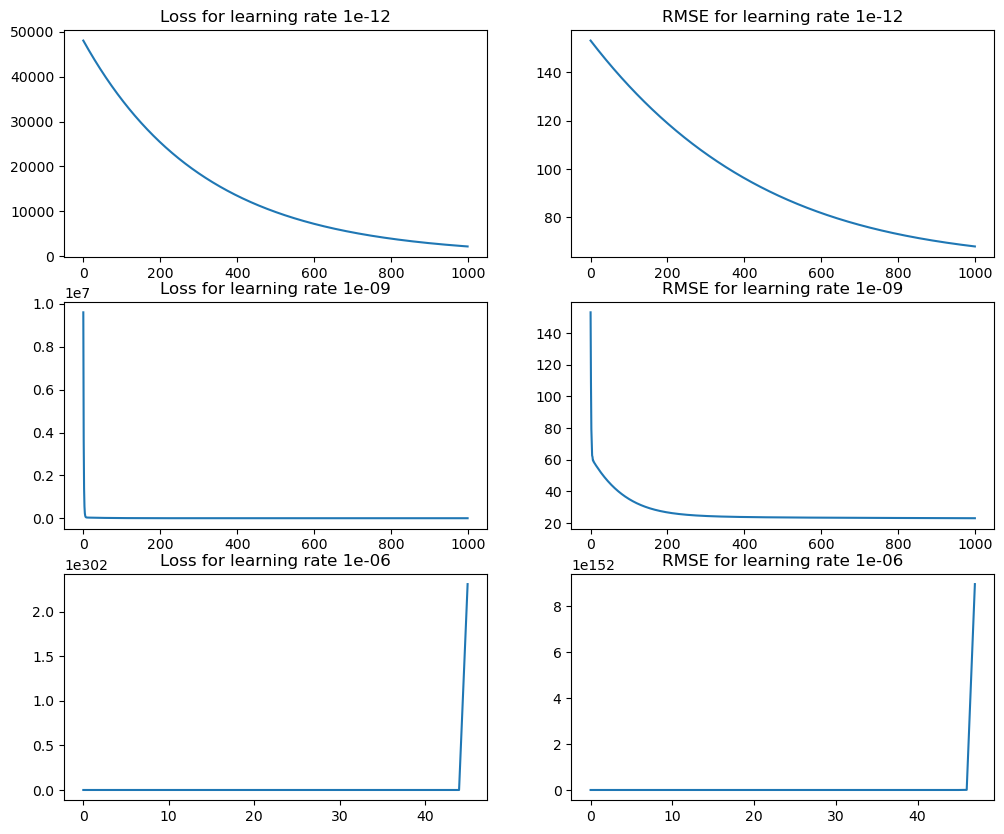

In [95]:
#Using smallest learning rate
converged1, beta_values1, loss_changes1 = learn_linreg_loss_min(Xtrain_airfare, ytrain_airfare, alpha1, "constant", i_max, eps)
#use beta_values to calculate rmse for each iteration
rmse_values1 = [calculate_rmse(beta, Xtest_airfare, ytest_airfare) for beta in beta_values1]


#Using intermediate learning rate
converged2, beta_values2, loss_changes2 = learn_linreg_loss_min(Xtrain_airfare, ytrain_airfare, alpha2, "constant", i_max, eps)
rmse_values2 = [calculate_rmse(beta, Xtest_airfare, ytest_airfare) for beta in beta_values2]



#Using largest learning rate
converged3, beta_values3, loss_changes3 = learn_linreg_loss_min(Xtrain_airfare, ytrain_airfare, alpha3, "constant", i_max, eps)
rmse_values3 = [calculate_rmse(beta, Xtest_airfare, ytest_airfare) for beta in beta_values3]

print(f"Convergence with {alpha1}:", converged1)
print(f"Convergence with {alpha2}:", converged2)
print(f"Convergence with {alpha3}:", converged3)

fig, axes = plt.subplots(3,2, figsize=(12,10))
axes[0,0].plot(loss_changes1)
axes[0,0].set_title(f"Loss for learning rate {alpha1}")
axes[0,1].plot(rmse_values1)
axes[0,1].set_title(f"RMSE for learning rate {alpha1}")
axes[1,0].plot(loss_changes2)
axes[1,0].set_title(f"Loss for learning rate {alpha2}")
axes[1,1].plot(rmse_values2)
axes[1,1].set_title(f"RMSE for learning rate {alpha2}")
axes[2,0].plot(loss_changes3)
axes[2,0].set_title(f"Loss for learning rate {alpha3}")
axes[2,1].plot(rmse_values3)
axes[2,1].set_title(f"RMSE for learning rate {alpha3}")


The smallest learning rate leads to very slow minimization of both the loss function and RMSE. In contrast, the intermediate learning rate results in an initially exponential decrease in loss and RMSE, indicating effective early progress. However, after reaching a certain threshold, the improvements plateau, and the model fails to fully converge—likely due to the fixed step size being insufficiently adaptive. On the other hand, the largest learning rate causes the loss to increase exponentially, suggesting that the updates consistently overshoot the minimum, leading to divergence.

For the Red-wine dataset

Convergence for 1e-12: False
Convergence for 1e-09: False
Convergence for 1e-06: False


/tmp/ipykernel_14105/513526406.py:123: RuntimeWarning: overflow encountered in matmul
  return (y_train - X_train @ beta).T @ (y_train - X_train @ beta)


Text(0.5, 1.0, 'RMSE for learning rate 1e-06')

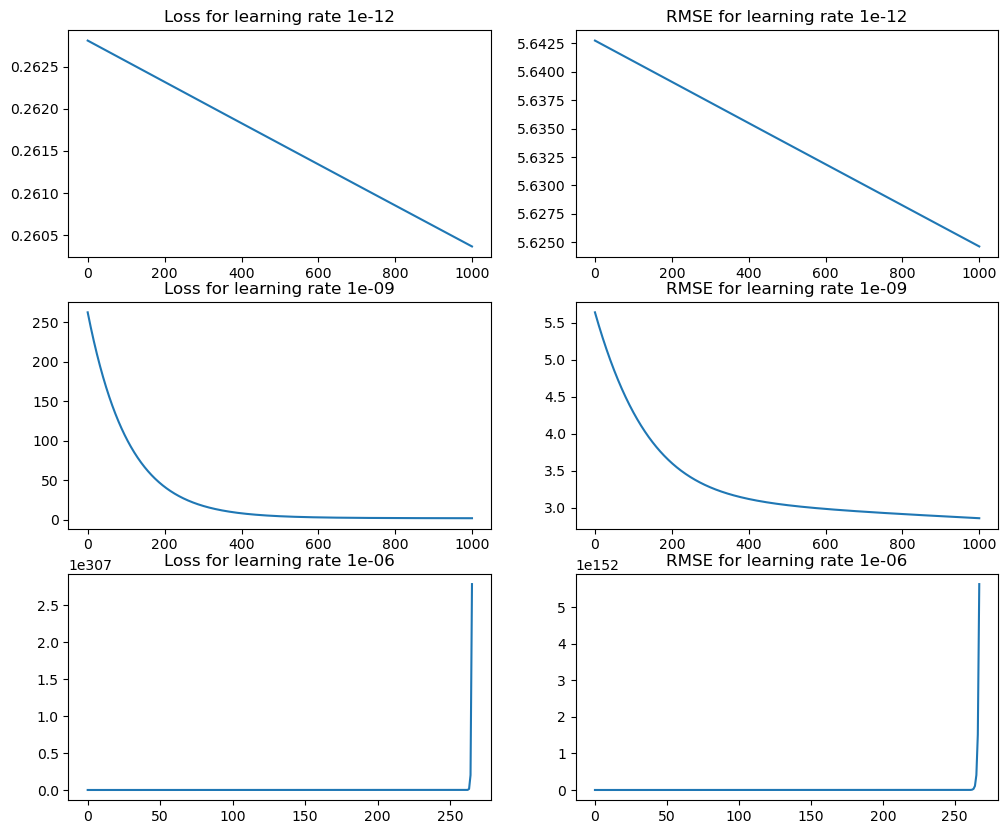

In [96]:
#smallest learning rate
converged1, beta_values1, loss_changes1 = learn_linreg_loss_min(Xtrain_wine_red, ytrain_wine_red, alpha1, "constant", i_max, eps)
#use beta_values to learn change in rmse
rmse_values1 = [calculate_rmse(beta, Xtest_wine_red, ytest_wine_red) for beta in beta_values1]


#intermediate learning rate
converged2, beta_values2, loss_changes2 = learn_linreg_loss_min(Xtrain_wine_red, ytrain_wine_red, alpha2, "constant", i_max, eps)
rmse_values2 = [calculate_rmse(beta, Xtest_wine_red, ytest_wine_red) for beta in beta_values2]


#largest learning rate
converged3, beta_values3, loss_changes3 = learn_linreg_loss_min(Xtrain_wine_red, ytrain_wine_red, alpha3, "constant", i_max, eps)
rmse_values3 = [calculate_rmse(beta, Xtest_wine_red, ytest_wine_red) for beta in beta_values3]

print(f"Convergence for {alpha1}:", converged1)
print(f"Convergence for {alpha2}:", converged2)
print(f"Convergence for {alpha3}:", converged3)

fig, axes = plt.subplots(3,2, figsize=(12,10))
axes[0,0].plot(loss_changes1)
axes[0,0].set_title(f"Loss for learning rate {alpha1}")
axes[0,1].plot(rmse_values1)
axes[0,1].set_title(f"RMSE for learning rate {alpha1}")
axes[1,0].plot(loss_changes2)
axes[1,0].set_title(f"Loss for learning rate {alpha2}")
axes[1,1].plot(rmse_values2)
axes[1,1].set_title(f"RMSE for learning rate {alpha2}")
axes[2,0].plot(loss_changes3)
axes[2,0].set_title(f"Loss for learning rate {alpha3}")
axes[2,1].plot(rmse_values3)
axes[2,1].set_title(f"RMSE for learning rate {alpha3}")

For the red wine dataset, the trend observed with the smallest learning rate suggests that the initial value of
$\beta$ was already close to the minimum of the loss function. The extremely small learning rate limited the updates, keeping the optimizer within a narrow region and preventing divergence. Although the intermediate learning rate caused a slight initial increase in loss—likely due to minor overshooting—it remained small enough to ensure gradual convergence. However, as with the airfare dataset, the fixed learning rate lacks adaptability, which can hinder convergence in more complex loss landscapes. The largest learning rate was too aggressive, causing the optimizer to repeatedly overshoot the minimum and ultimately diverge.

White-wine dataset

Convergence for 1e-12: False
Convergence for 1e-09: False
Convergence for 1e-06: False


/tmp/ipykernel_14105/513526406.py:123: RuntimeWarning: overflow encountered in matmul
  return (y_train - X_train @ beta).T @ (y_train - X_train @ beta)
/tmp/ipykernel_14105/513526406.py:147: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(((y_test - y_hat) ** 2).mean())
/home/ryan/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Text(0.5, 1.0, 'RMSE for learning rate 1e-06')

/home/ryan/anaconda3/lib/python3.12/site-packages/matplotlib/ticker.py:2119: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


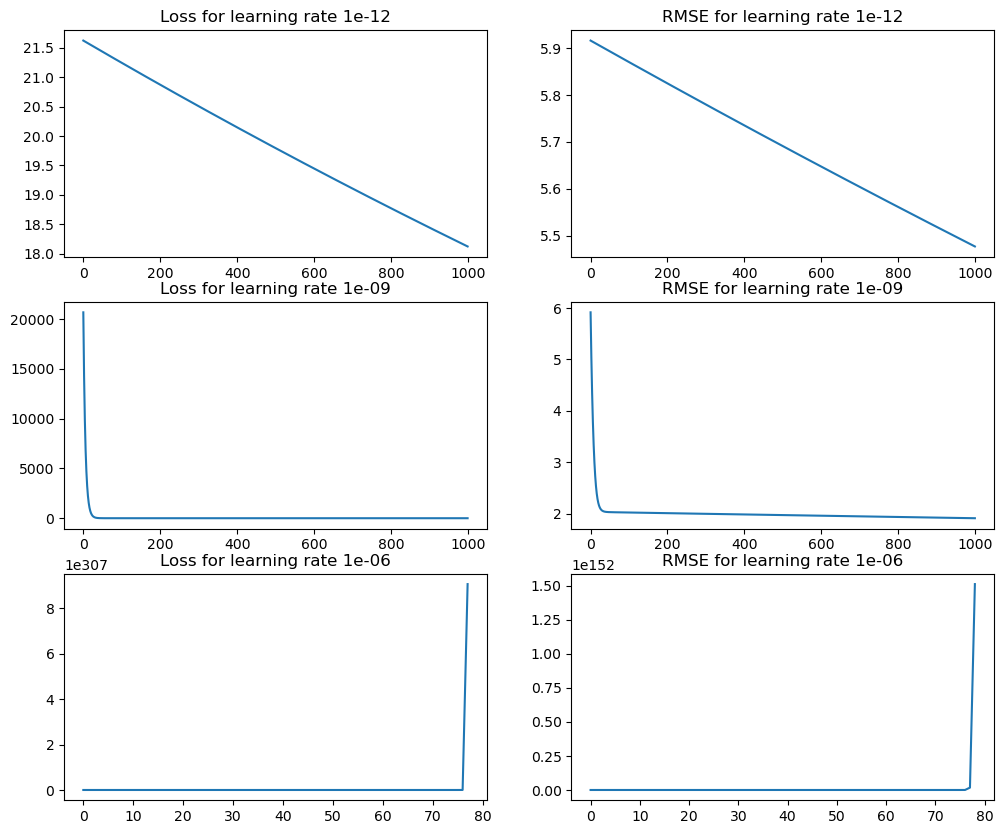

In [97]:
#smallest learning rate
converged1, beta_values1, loss_changes1 = learn_linreg_loss_min(Xtrain_wine_white, ytrain_wine_white, alpha1, "constant", i_max, eps)
#use beta_values to learn change in rmse
rmse_values1 = [calculate_rmse(beta, Xtest_wine_white, ytest_wine_white) for beta in beta_values1]


#intermediate learning rate
converged2, beta_values2, loss_changes2 = learn_linreg_loss_min(Xtrain_wine_white, ytrain_wine_white, alpha2, "constant", i_max, eps)
rmse_values2 = [calculate_rmse(beta, Xtest_wine_white, ytest_wine_white) for beta in beta_values2]


#largest learning rate
converged3, beta_values3, loss_changes3 = learn_linreg_loss_min(Xtrain_wine_white, ytrain_wine_white, alpha3, "constant", i_max, eps)
rmse_values3 = [calculate_rmse(beta, Xtest_wine_white, ytest_wine_white) for beta in beta_values3]

print(f"Convergence for {alpha1}:", converged1)
print(f"Convergence for {alpha2}:", converged2)
print(f"Convergence for {alpha3}:", converged3)

fig, axes = plt.subplots(3,2, figsize=(12,10))
axes[0,0].plot(loss_changes1)
axes[0,0].set_title(f"Loss for learning rate {alpha1}")
axes[0,1].plot(rmse_values1)
axes[0,1].set_title(f"RMSE for learning rate {alpha1}")
axes[1,0].plot(loss_changes2)
axes[1,0].set_title(f"Loss for learning rate {alpha2}")
axes[1,1].plot(rmse_values2)
axes[1,1].set_title(f"RMSE for learning rate {alpha2}")
axes[2,0].plot(loss_changes3)
axes[2,0].set_title(f"Loss for learning rate {alpha3}")
axes[2,1].plot(rmse_values3)
axes[2,1].set_title(f"RMSE for learning rate {alpha3}")

The trends of the grpahs for the white-wine dataset is similar to that of the red-wine dataset.

# Using Armijo and Boldrriver as step-length functions

Using the airfare dataset

Convergence for armijo: False
Convergence for bolddriver: False


Text(0.5, 1.0, 'RMSE using bolddriver')

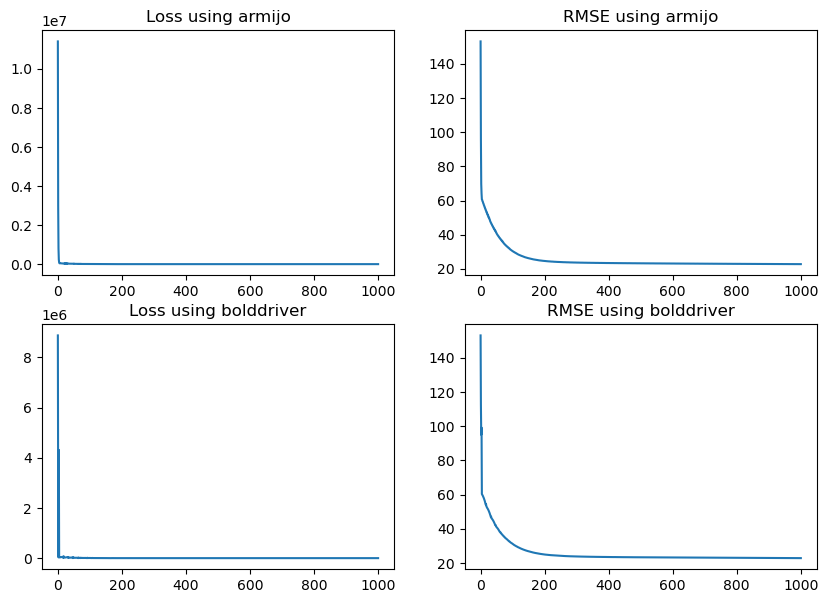

In [98]:
#Armijo
converged1, beta_values1, loss_changes1 = learn_linreg_loss_min(Xtrain_airfare, ytrain_airfare, None, "armijo", i_max, eps)
#use beta_values to learn change in rmse
rmse_values1 = [calculate_rmse(beta, Xtest_airfare, ytest_airfare) for beta in beta_values1]

#Bolddriver
converged2, beta_values2, loss_changes2 = learn_linreg_loss_min(Xtrain_airfare, ytrain_airfare, 1, "bolddriver", i_max, eps)
#use beta_values to learn change in rmse
rmse_values2 = [calculate_rmse(beta, Xtest_airfare, ytest_airfare) for beta in beta_values2]


print("Convergence for armijo:", converged1)
print("Convergence for bolddriver:", converged2)



fig, axes = plt.subplots(2,2, figsize=(10,7))
axes[0,0].plot(loss_changes1)
axes[0,0].set_title("Loss using armijo")
axes[0,1].plot(rmse_values1)
axes[0,1].set_title("RMSE using armijo")
axes[1,0].plot(loss_changes2)
axes[1,0].set_title("Loss using bolddriver")
axes[1,1].plot(rmse_values2)
axes[1,1].set_title("RMSE using bolddriver")


The Armijo and Bolddriver function in calculating the learning rate for each iteration exponentially decreases the loss function and the RMSE and almost converges to a minimum

For Red-wine

Convergence for armijo: True
Convergence for bolddriver: True
0.09897571374187919


Text(0.5, 1.0, 'RMSE using bolddriver')

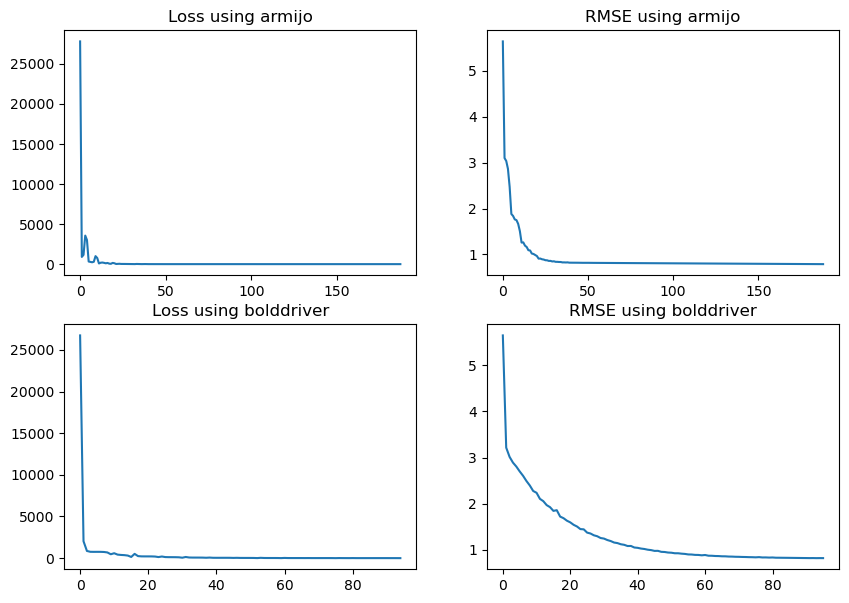

In [99]:
#Armijo
converged1, beta_values1, loss_changes1 = learn_linreg_loss_min(Xtrain_wine_red, ytrain_wine_red, None, "armijo", i_max, eps)
#use beta_values to learn change in rmse
rmse_values1 = [calculate_rmse(beta, Xtest_wine_red, ytest_wine_red) for beta in beta_values1]

#Bolddriver
converged2, beta_values2, loss_changes2 = learn_linreg_loss_min(Xtrain_wine_red, ytrain_wine_red, 1, "bolddriver", i_max, eps)
#use beta_values to learn change in rmse
rmse_values2 = [calculate_rmse(beta, Xtest_wine_red, ytest_wine_red) for beta in beta_values2]


print("Convergence for armijo:", converged1)
print("Convergence for bolddriver:", converged2)

print(loss_changes1[-1])


fig, axes = plt.subplots(2,2, figsize=(10,7))
axes[0,0].plot(loss_changes1)
axes[0,0].set_title("Loss using armijo")
axes[0,1].plot(rmse_values1)
axes[0,1].set_title("RMSE using armijo")
axes[1,0].plot(loss_changes2)
axes[1,0].set_title("Loss using bolddriver")
axes[1,1].plot(rmse_values2)
axes[1,1].set_title("RMSE using bolddriver")

The Armijo step-size function reduces the loss, converging quickly but with a few overshoots initially due to aggressive step size before shrinking. The bolddriver step-size function converges more conservatively avoiding overshoots.

For white-wine

Convergence for armijo: False
Convergence for bolddriver: False


Text(0.5, 1.0, 'RMSE using bolddriver')

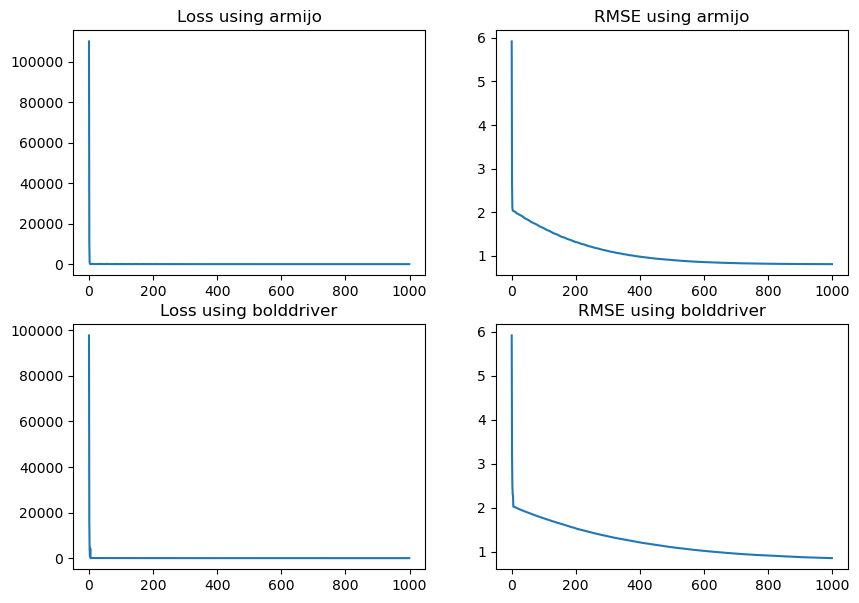

In [100]:
#Armijo
converged1, beta_values1, loss_changes1 = learn_linreg_loss_min(Xtrain_wine_white, ytrain_wine_white, None, "armijo", i_max, eps)
#use beta_values to learn change in rmse
rmse_values1 = [calculate_rmse(beta, Xtest_wine_white, ytest_wine_white) for beta in beta_values1]

#Bolddriver
converged2, beta_values2, loss_changes2 = learn_linreg_loss_min(Xtrain_wine_white, ytrain_wine_white, 1, "bolddriver", i_max, eps)
#use beta_values to learn change in rmse
rmse_values2 = [calculate_rmse(beta, Xtest_wine_white, ytest_wine_white) for beta in beta_values2]


print("Convergence for armijo:", converged1)
print("Convergence for bolddriver:", converged2)


fig, axes = plt.subplots(2,2, figsize=(10,7))
axes[0,0].plot(loss_changes1)
axes[0,0].set_title("Loss using armijo")
axes[0,1].plot(rmse_values1)
axes[0,1].set_title("RMSE using armijo")
axes[1,0].plot(loss_changes2)
axes[1,0].set_title("Loss using bolddriver")
axes[1,1].plot(rmse_values2)
axes[1,1].set_title("RMSE using bolddriver")

For the white-wine dataset both the step-size function are able to adaptively reduce the loss function exponentially fast.